在预训练完成之后，将其他层参数固定，只训练输出层

In [7]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import optuna

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from modules import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [8]:
class Patch_TST(nn.Module):
    """Patch Time Series Transformer"""
    def __init__(self, input_size, seq_len, patch_size, stride, num_layer, num_head, d_model, masking_ratio, mask_expand_size, dropout_1, dropout_2, dropout_3):
        super().__init__()
        self.device = 'cuda:0'
        self.input_size = input_size
        self.patch_size = patch_size
        self.stride = stride
        self.masking_ratio = masking_ratio
        self.mask_expand_size = mask_expand_size

        self.num_patch = int(np.floor((seq_len - patch_size) / stride) + 1)

        self.patch = TimeSeriesPatcher(patch_size, stride) # 首先经过patcher分成子序列

        self.projection = PatchProjection(input_size, patch_size, d_model = d_model, dropout = dropout_1)

        self.encoder = MultiLayerEncoder(dim_feature = d_model, dim_sequence = self.num_patch, num_enc_layer = num_layer, num_head = num_head, num_ffn_hidden = d_model*2, dropout = dropout_2)

        self.reconstruction = nn.Linear(d_model, input_size * patch_size)
        
        self.output = nn.Sequential(
            nn.Flatten(start_dim = -2),
            nn.Linear(self.num_patch * d_model, self.num_patch * d_model),
            nn.Dropout(dropout_3),
            HybridDecoder(dim_state = self.num_patch * d_model, init_prob = [0.0,0.0,0.0])
        )
    
    def self_supervised(self, x):
        """
        自监督预训练
        如果不允许patch重叠，正好被patch隔断的形态无法学习到。
        允许patch重叠，则模型预训练的时候可以从前后patch偷看到信息。
        需要用双重mask
        target mask 是真正需要重建的patch
        input mask 是target mask的扩展，根据系数向两侧扩展掩蔽范围。例如假如patch允许重叠50%，则向前后各多屏蔽一个patch就可以完全屏蔽掉信息。
        """
        device = x.device
        batch_size = x.shape[0]


        noise = torch.rand(size=(batch_size, self.num_patch), device=device)
        target_mask = noise < self.masking_ratio
        
        # 防止出现所有 patch 都没被 mask 的情况，至少 mask 一个随机选择一个 patch 进行 mask
        if not target_mask.any(dim=1).all():
            for i in range(batch_size):
                if not target_mask[i].any():
                    fallback_idx = torch.randint(0, self.num_patch, (1,)).item()
                    target_mask[i, fallback_idx] = True

        target_mask_float = target_mask.float().unsqueeze(1)
        kernel_size = 2 * self.mask_expand_size + 1
        kernel = torch.ones(1, 1, kernel_size, device=device)
        padding = self.mask_expand_size
        expanded_mask_float = F.conv1d(target_mask_float, kernel, padding=padding)
        input_mask = (expanded_mask_float > 0).squeeze(1)


        x_patched = self.patch(x)
        reshape_mask = input_mask.unsqueeze(-1)
        x_masked = torch.where(reshape_mask, 0.0, x_patched)
        x_projected = self.projection(x_masked)
        x_encodered = self.encoder(x_projected)
        
        x_pre_reconstruction = x_encodered[target_mask] # 仅关注target mask
        x_reconstructed = self.reconstruction(x_pre_reconstruction)
        x_target = x_patched[target_mask] # 仅关注target mask

        return x_reconstructed, x_target
    
    def forward(self, x):
        """前向传播输出"""
        x_patched = self.patch(x)
        x_projected = self.projection(x_patched)
        x_encodered = self.encoder(x_projected)
        output = self.output(x_encodered)
        return output
        


In [9]:
# 固定参数组
seq_len = 120
patch_size = 8
num_layer = 2
num_head = 16
d_model = 128

masking_ratio = 0.2
mask_expand_size = 1
stride = 4

assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]


In [10]:
recorder = PredictionRecorder()
animator = TrainMonitor(figsize=(12,6))

In [11]:
# 二阶段 prediction训练
def objective(trial):

    # 训练输出层需要调优的可变参数
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    dropout_1 = 0.1 # 已经不需要了，但是实例化模型的时候还是需要设置一个
    dropout_2 = 0.1 # 已经不需要了，但是实例化模型的时候还是需要设置一个
    dropout_3 = trial.suggest_float("dropout_3", 0.0, 0.7)

    learning_rate = trial.suggest_float("learning_rate", 1e-10, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-1, log=True)
    
    alpha = trial.suggest_float("alpha", 1e-2, 1e-1, log=True)
    delta = trial.suggest_float("delta", 1.0, 1.3)
    gamma = trial.suggest_float("gamma", 0.7, 1, log=True)


    # 提取数据
    feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
    label_columns = ['label_return','down_prob','middle_prob','up_prob']

    feature = []
    label = []
    for asset_code in assets_list:
        data = pd.read_csv(f'data/{asset_code}.csv')
        data = data[data['trade_date'] < 20230901].copy()
        feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
        label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

    feature = torch.stack(feature, dim = 1)
    label = torch.stack(label, dim = 1)
    feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
    label = label[seq_len-1:]
    data = RandomLoader(feature, label)


    precision_list = []

    for i in range(10):
        animator.reset()

        train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.6,0.1], balance=[True, False]) # 这里我们随机取10个不同的测试集进行训练，并且设置balance = False，模拟可能遇到的不同市场环境，选择总体最为稳健的训练参数

        model = Patch_TST(input_size = 10,
                        seq_len = seq_len,
                        patch_size = patch_size,
                        stride = stride,
                        num_layer = num_layer, 
                        num_head = num_head,
                        d_model = d_model,
                        masking_ratio = masking_ratio,
                        mask_expand_size = mask_expand_size,
                        dropout_1 = dropout_1,
                        dropout_2 = dropout_2,
                        dropout_3 = dropout_3,
                        ).to('cuda:0')
        model.load_state_dict(torch.load('params/self_supervised_1.params'))

        # 对预训练部分设置不同学习率

        optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
        loss_fn = HybridLoss(alpha = alpha, delta = delta, show_loss = False)
        train = ModelTrain(model = model, train_loader = train_loader, test_loader = test_loader, loss_fn = loss_fn, optimizer = optimizer, scheduler = scheduler, recorder = recorder,graph = animator)

        prediction, precision = train.epoch_train(epochs = 20, early_stop = 100)
        precision_list.append(precision)
    
    return np.mean(precision_list)/np.std(precision_list)

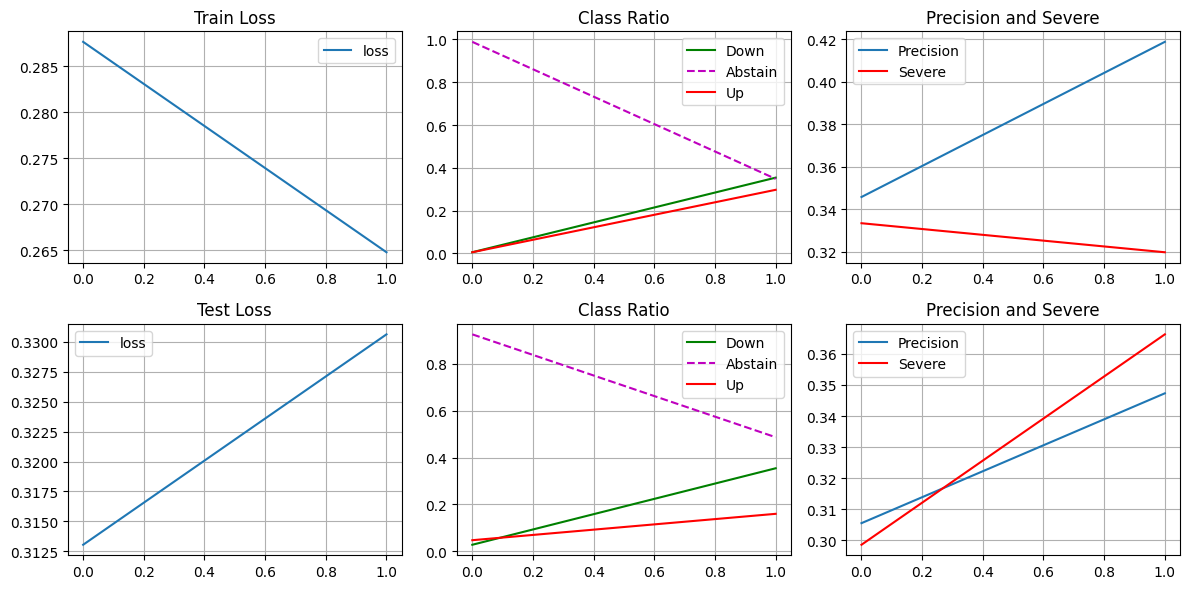

  0%|          | 0/436 [00:00<?, ?it/s]

In [ ]:
study = optuna.create_study(
    direction="maximize",
    # study_name="patchtstprediction",
    # storage="sqlite:///data/db.sqlite3_prediction",  # 保存到 SQLite 文件
    # load_if_exists=True # 如果存在同名study，则加载它
)

study.optimize(objective, n_trials=30)
print("最佳准确率: ", study.best_value)
print("最佳超参数: ", study.best_params)
df = study.trials_dataframe()
df.sort_values(by='value', ascending=False)

In [ ]:
# df.sort_values(by='value', ascending=False)

In [ ]:
# fig = optuna.visualization.plot_optimization_history(study)
# fig.show()

In [ ]:
# fig = optuna.visualization.plot_param_importances(study)
# fig.show()

In [ ]:
# df.sort_values(by='value', ascending=False)

最佳超参数:  {'batch_size ': 256, 'dropout_3': 0.2, 'learning_rate_output': 1e-4, 'weight_decay_output': 1e-4}

最佳准确率:  4.177628846327211
最佳超参数:  {'batch_size ': 64, 'dropout_3': 0.16302522951448722, 'learning_rate_output': 0.0002574122864472939, 'weight_decay_output': 0.0004618348719819646}

最佳准确率:  2.9682305245993987
最佳超参数:  {'dropout_3': 0.04133271735001662, 'learning_rate_output': 2.9238558770898543e-05, 'weight_decay_output': 0.02537110757981112, 'alpha': 0.07128340804345366, 'delta': 1.1042477118535177, 'gamma': 0.8022416523562959}

In [ ]:
# 提取数据
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

feature = []
label = []

for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    data = data[data['trade_date'] < 20230901].copy() # 所有2023年以后数据不参与训练
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)

feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]

feature = torch.flatten(feature, start_dim=0, end_dim = 1)
label = torch.flatten(label, start_dim=0, end_dim = 1)

data = RandomLoader(feature, label)
recorder = PredictionRecorder()
animator = TrainMonitor(figsize=(12,6))

In [ ]:
# 可变参数组
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX']
# assets_list = ['JM.DCE','RB.SHF','HC.SHF', 'I.DCE',]
# assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]

batch_size = 64
dropout_3 = 0.5
learning_rate = 1e-5
weight_decay = 0

alpha = 0.005
delta = 1.2
gamma = 0.7

train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.75,0.24], balance=[True, True])

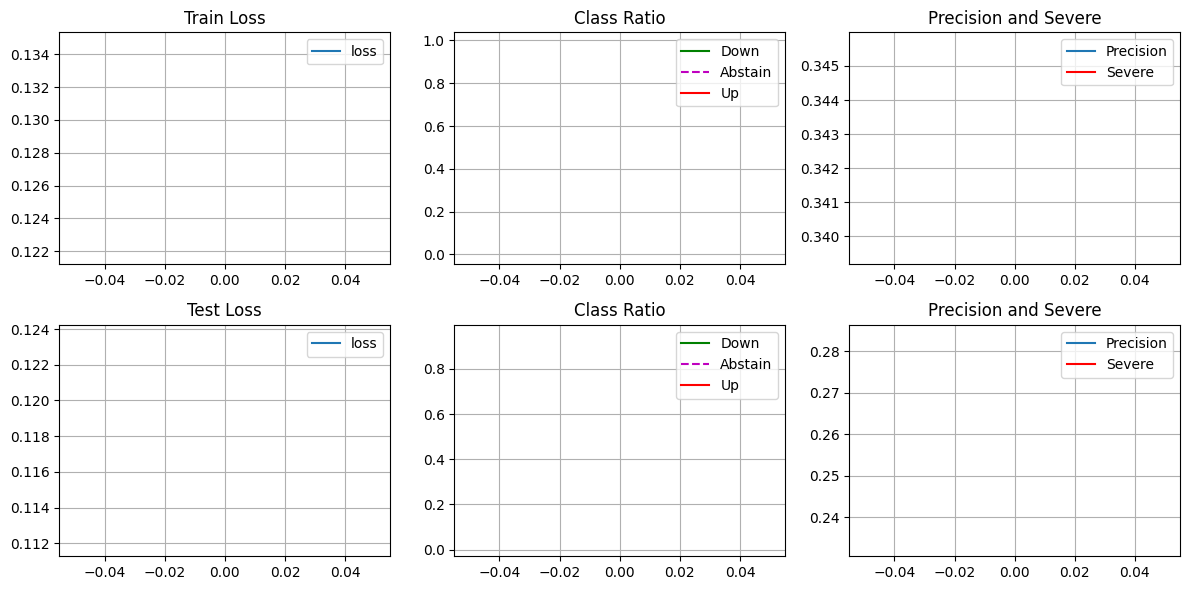

 47%|████▋     | 102/218 [00:01<00:01, 96.53it/s]

In [ ]:
# 训练
model = Patch_TST(input_size = 10,
                    seq_len = seq_len,
                    patch_size = patch_size,
                    stride = stride,
                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,
                    masking_ratio = masking_ratio,
                    mask_expand_size = mask_expand_size,
                    dropout_1 = dropout_1,
                    dropout_2 = dropout_2,
                    dropout_3 = dropout_3,
                    ).to('cuda:0')
model.load_state_dict(torch.load('params/self_supervised_1.params'))
# zero_bias = torch.tensor([0.0, 0.0, 0.0], device = 'cuda:0')
# model.output[2].log_prob[0].bias.data = zero_bias


optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
loss_fn = HybridLoss(alpha = alpha, delta = delta, show_loss = False)


train = ModelTrain(model = model, train_loader = train_loader, test_loader = test_loader, loss_fn = loss_fn, optimizer = optimizer, scheduler = scheduler, recorder = recorder, graph = animator)
# 备注：这里我修改了一下 ModelTrain
# 在训练轮次调用self.model.train() 之后，调用了
# self.model.encoder.eval()
# self.model.projection.eval()
# 来使前置的编码层进入不更新参数和完全体输出的状态，服务于输出层的训练

prediction, precision = train.epoch_train(epochs = 3, early_stop = 100)

torch.save(model.state_dict(), 'params/supervised_1.params')


In [ ]:
# all_assets = pd.DataFrame({
#     'stage_1_prediction': np.mean(result, axis = 0)[:,0],
#     'stage_2_prediction': np.mean(result, axis = 0)[:,2],

#     'stage_1_precision': np.mean(result, axis = 0)[:,1],
#     'stage_2_precision': np.mean(result, axis = 0)[:,3],

#     'stage_1_precision_std': np.std(result, axis = 0)[:,1],
#     'stage_2_precision_std': np.std(result, axis = 0)[:,3],
# })
# # all_assets.index = pd.Series(assets_list)
# for col in all_assets.columns:
#     all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")

# # 转换为Markdown
# markdown_table = all_assets.to_markdown(index=False)
# print(markdown_table)